# **nanoGPT-RXTX**
Trains nanoGPT with custom RXTX matmuls in optimizer and attention layer.
RXTX is a new matmul algorithm that computes the product of matrix by its transpose XX^T, introduced in this Paper: https://arxiv.org/abs/2405.14619. It uses 5% fewer matmuls ops than SOTA algorithms.

**Key features**

RXTX in Attention Layer
   - Computes attention scores with a 4x4 blockwise RXTX matmuls instead of standard pytorch dot product.
   - Handles arbitrary sequence lengths by padding to the nearest multiple of 4 (satisfies RXTX req).

RXTX in Optimizer (RXTXShampoo)
   - Implements an RXTX variant of shampoo with params reshaped into 4x4 blocks during each optimizer step.
   - Includes stability features: clamping, NaN guards, and identity fallback for failed inversions

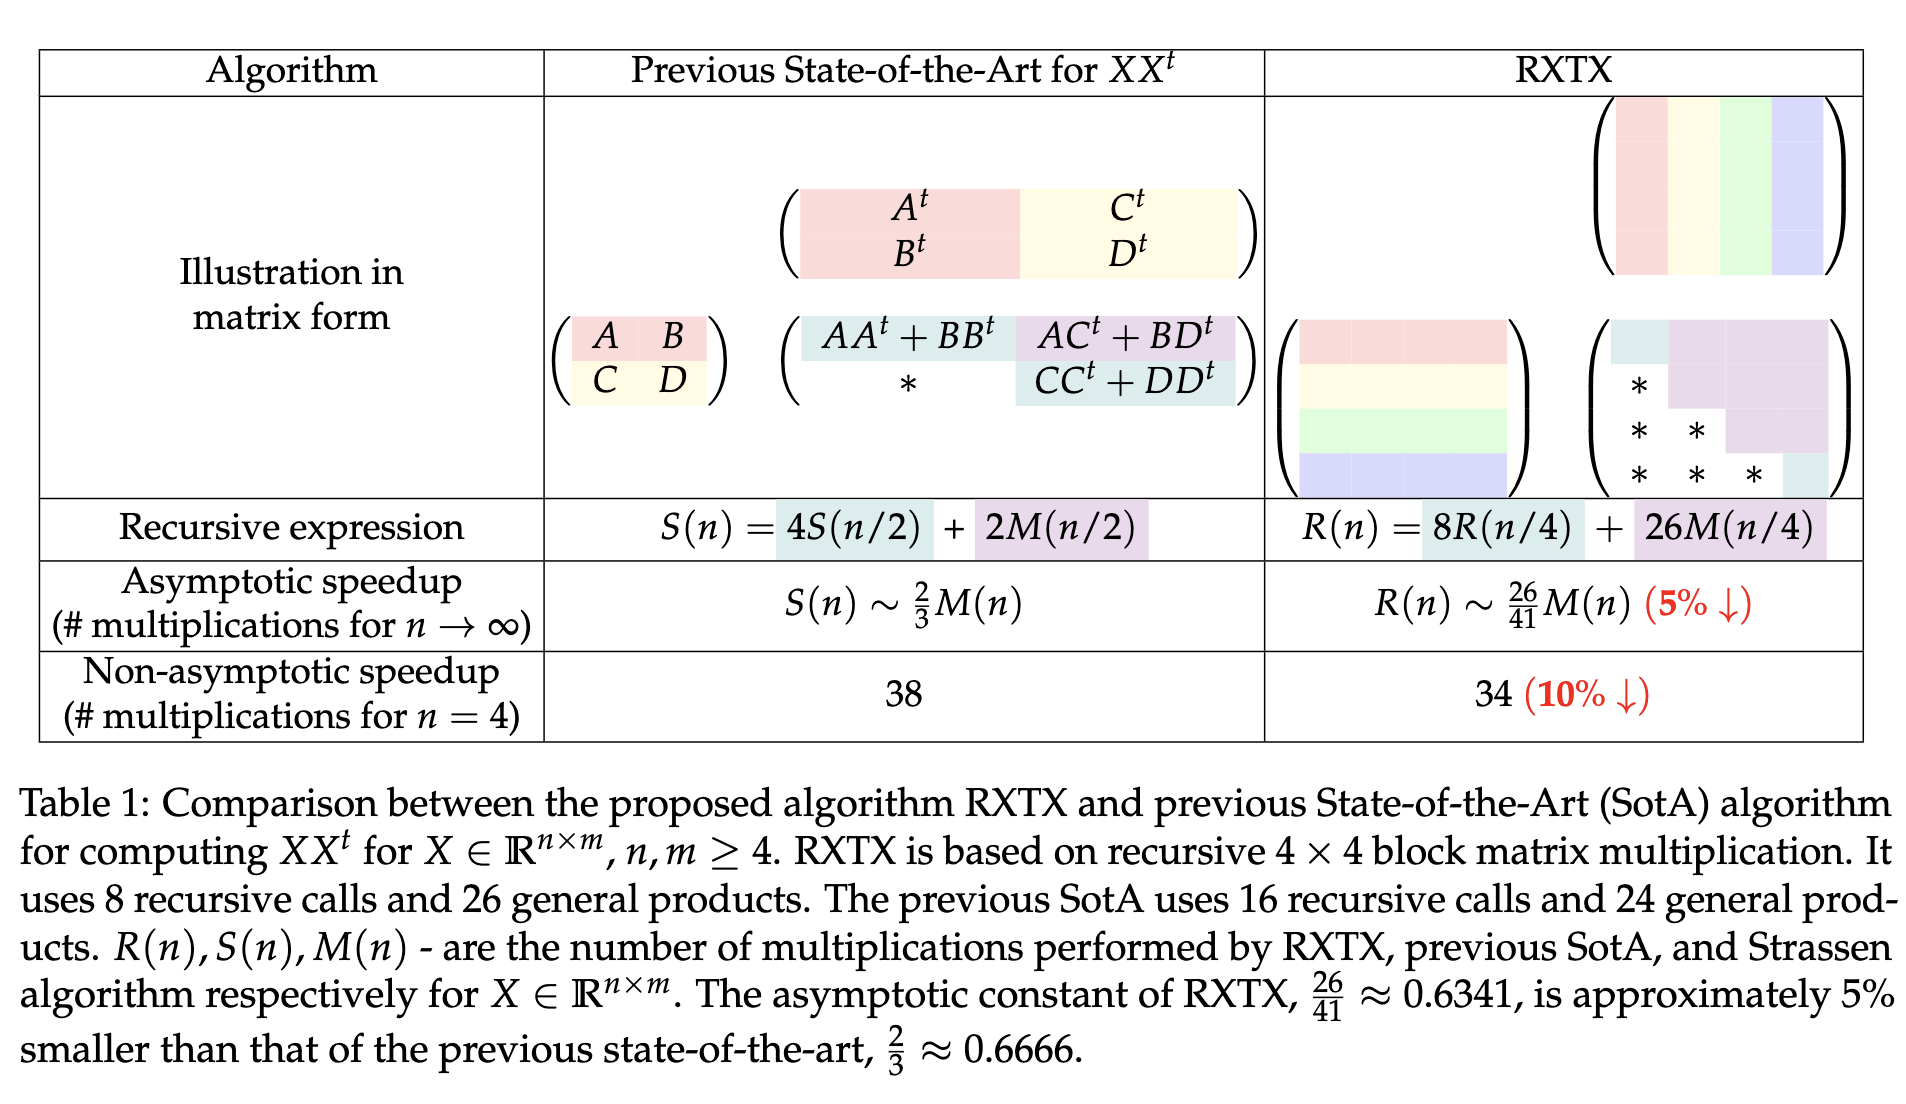

Using device: cpu
Dataset already exists at input.txt.
Vocabulary size: 65
Training data size: 1003854 characters
Testing data size: 111540 characters
Step 1, Train Loss: 4.2666, Val Loss: 4.2474, RXTX Calls: 97500, Avg RXTX Time: 0.000001s, Identity Fallbacks: 0
Step 2, Train Loss: 4.2321, Val Loss: 4.2120, RXTX Calls: 97500, Avg RXTX Time: 0.000001s, Identity Fallbacks: 0
Step 3, Train Loss: 4.2131, Val Loss: 4.2053, RXTX Calls: 97500, Avg RXTX Time: 0.000001s, Identity Fallbacks: 0
Step 4, Train Loss: 4.1602, Val Loss: 4.1393, RXTX Calls: 97500, Avg RXTX Time: 0.000001s, Identity Fallbacks: 0
Step 5, Train Loss: 4.0945, Val Loss: 4.0583, RXTX Calls: 97500, Avg RXTX Time: 0.000001s, Identity Fallbacks: 0
Step 6, Train Loss: 4.0161, Val Loss: 3.9284, RXTX Calls: 97500, Avg RXTX Time: 0.000001s, Identity Fallbacks: 0
Step 7, Train Loss: 3.8506, Val Loss: 3.7863, RXTX Calls: 97500, Avg RXTX Time: 0.000001s, Identity Fallbacks: 0
Step 8, Train Loss: 3.7245, Val Loss: 3.6876, RXTX Calls: 

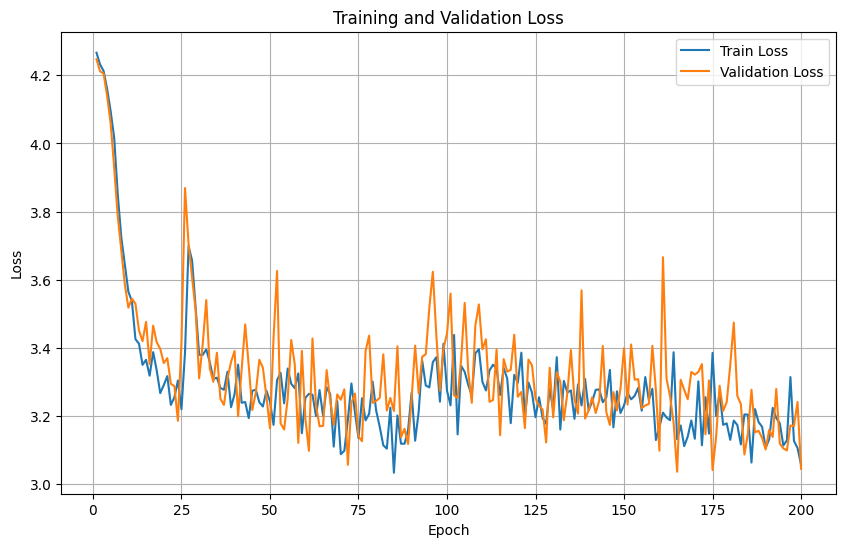

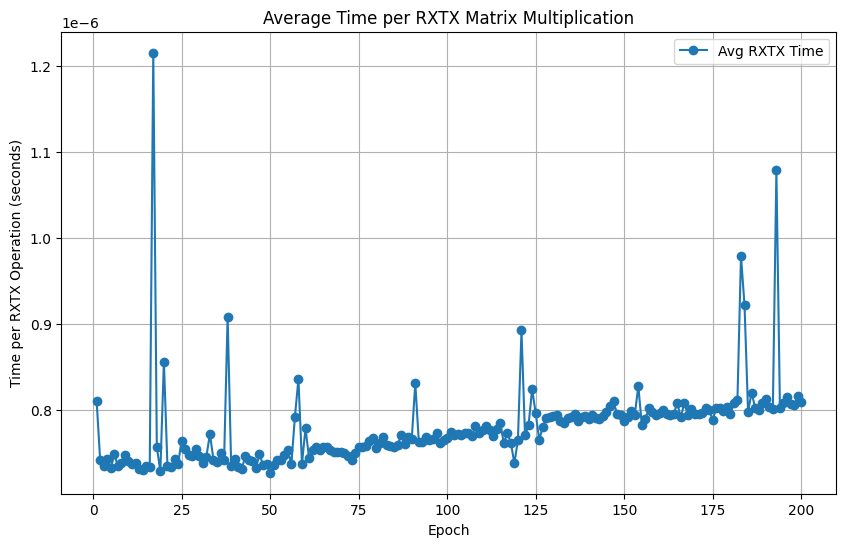

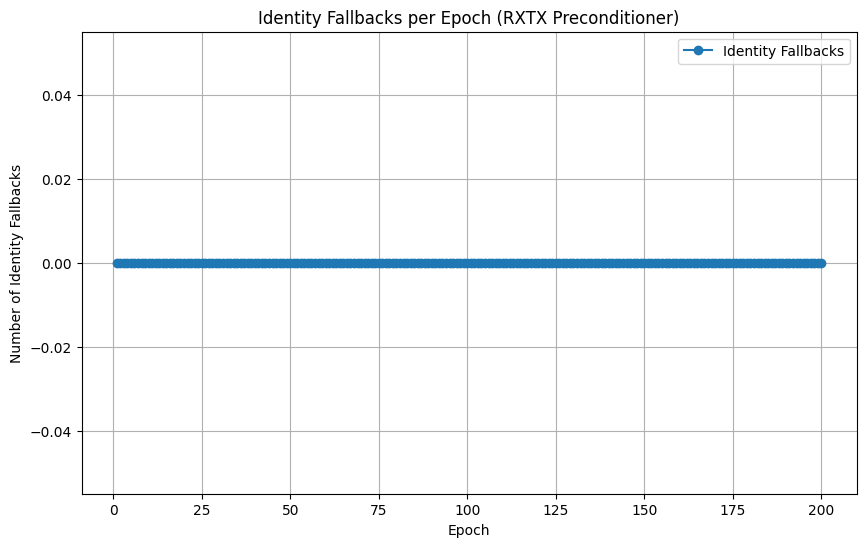

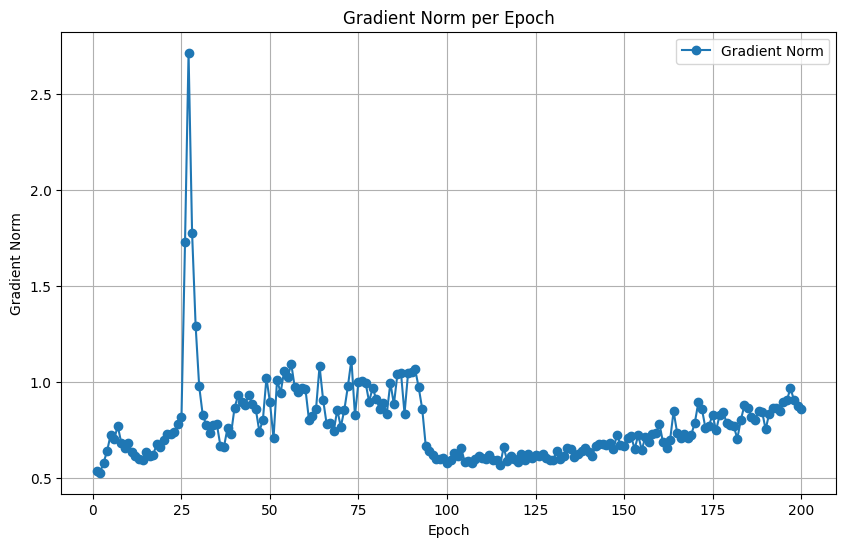

In [ ]:
import os
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"Using device: {device}")

# Prep Data
def dataset(url, filepath):
    if not os.path.exists(filepath):
        print(f"Downloading dataset from {url}...")
        response = requests.get(url)
        with open(filepath, 'wb') as f:
            f.write(response.content)
        print(f"Dataset downloaded and saved to {filepath}.")
    else:
        print(f"Dataset already exists at {filepath}.")

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = "input.txt"
dataset(url, filepath)
with open('input.txt', 'r') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Vocabulary size: {vocab_size}")

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

def encode(text):
    return torch.tensor([stoi[c] for c in text], dtype=torch.long)

def decode(indices):
    return ''.join([itos[i.item()] for i in indices])

data = encode(text)
n = int(0.9 * len(data))
train_data = data[:n].to(device)
test_data = data[n:].to(device)
print(f"Training data size: {train_data.numel()} characters")
print(f"Testing data size: {test_data.numel()} characters")

# RXTX implementation for 4x4 matrices
def rxtx_4x4(X):
    global rxtx_count, rxtx_time
    start_time = time.time()
    
    n, m = X.shape
    if n != 4 or m != 4:
        raise ValueError(f"Input must be a 4x4 matrix, got {n}x{m}")
    
    # Extract elements
    X = X.detach().cpu().numpy()
    # Clamp input to prevent extreme values
    X = np.clip(X, -100, 100)
    if np.any(np.isnan(X)):
        print(f"Warning: NaN detected in rxtx_4x4 input after clamping")
    X1, X2, X3, X4 = X[0,0], X[0,1], X[0,2], X[0,3]
    X5, X6, X7, X8 = X[1,0], X[1,1], X[1,2], X[1,3]
    X9, X10, X11, X12 = X[2,0], X[2,1], X[2,2], X[2,3]
    X13, X14, X15, X16 = X[3,0], X[3,1], X[3,2], X[3,3]
    
    # Compute 26 general products (m1 to m26)
    m1 = (-X2 + X3 - X4 + X8) * (X8 + X11)
    m2 = (X1 - X5 - X6 + X7) * (X15 + X5)
    m3 = (-X2 + X12) * (-X10 + X16 + X12)
    m4 = (X9 - X6) * (X13 + X9 - X14)
    m5 = (X2 + X11) * (-X6 + X15 - X7)
    m6 = (X6 + X11) * (X6 + X7 - X11)
    m7 = X11 * (X6 + X7)
    m8 = X2 * (-X14 - X10 + X6 - X15 + X7 + X16 + X12)
    m9 = X6 * (X13 + X9 - X14 - X10 + X6 + X7 - X11)
    m10 = (X2 - X3 + X7 + X11 + X4 - X8) * X11
    m11 = (X5 + X6 - X7) * X5
    m12 = (X2 - X3 + X4) * X8
    m13 = (-X1 + X5 + X6 + X3 - X7 + X11) * X15
    m14 = (-X1 + X5 + X6) * (X13 + X9 + X15)
    m15 = (X2 + X4 - X8) * (X11 + X16 + X12)
    m16 = (X1 - X8) * (X9 - X16)
    m17 = X12 * (X10 - X12)
    m18 = X9 * (X13 - X14)
    m19 = (-X2 + X3) * (-X15 + X7 + X8)
    m20 = (X5 + X9 - X8) * X9
    m21 = X8 * (X9 - X8 + X12)
    m22 = (-X6 + X7) * (X5 + X7 - X11)
    m23 = X1 * (X13 - X5 + X16)
    m24 = (-X1 + X4 + X12) * X16
    m25 = (X9 + X2 + X10) * X14
    m26 = (X6 + X10 + X12) * X10
    
    # Placeholder for recursive symmetric products
    s1 = s2 = s3 = s4 = s5 = s6 = s7 = s8 = 0
    
    # Compute intermediate terms (Algorithm 3)
    z1 = m7 - m11 - m12
    z2 = m1 + m12 + m21
    z3 = m3 + m17 - m24
    z4 = m2 + m11 + m23
    z5 = m5 + m7 + m8
    z6 = m4 - m18 - m20
    z7 = m6 - m7 - m9
    z8 = m17 + m18
    
    # Compute output matrix C
    C = np.zeros((4, 4))
    C[0,0] = s1 + s2 + s3 + s4
    C[0,1] = m2 - m5 - z1 + m13 + m19
    C[0,2] = z2 + z3 + m15 + m16
    C[0,3] = z4 - z3 - z5 - m13
    C[1,1] = m1 + m6 - z1 + m10 + m22
    C[1,2] = z2 - z6 + z7 + m10
    C[1,3] = z4 + z6 + m14 + m16
    C[2,2] = m4 - z7 - z8 + m26
    C[2,3] = m3 + z5 + z8 + m25
    C[3,3] = s5 + s6 + s7 + s8
    C[1,0] = C[0,1]
    C[2,0] = C[0,2]
    C[2,1] = C[1,2]
    C[3,0] = C[0,3]
    C[3,1] = C[1,3]
    C[3,2] = C[2,3]
    
    # Clamp output to prevent NaNs
    C = np.clip(C, -100, 100)
    if np.any(np.isnan(C)):
        print(f"Warning: NaN detected in rxtx_4x4 output after clamping")
        C = np.nan_to_num(C, nan=0.0)
    
    rxtx_count += 26
    rxtx_time += time.time() - start_time
    return torch.tensor(C, dtype=torch.float32, device=device)

# Track identity fallbacks
identity_fallbacks = 0

# RXTX-based Shampoo Optimizer (RXTX-only, 4x4 only)
class RXTXShampoo(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, beta=0.9, epsilon=1e-2, momentum=0.9):
        defaults = dict(lr=lr, beta=beta, epsilon=epsilon, momentum=momentum)
        super(RXTXShampoo, self).__init__(params, defaults)

    def step(self):
        global rxtx_count, rxtx_time, identity_fallbacks
        for group in self.param_groups:
            lr = group['lr']
            beta = group['beta']
            epsilon = group['epsilon']
            momentum = group['momentum']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]
                
                if torch.any(torch.isnan(grad)):
                    print(f"Warning: NaN detected in gradient for parameter {p.shape}")
                
                # Reshape gradient to matrix
                grad_flat = grad.view(-1, grad.size(-1)) if grad.dim() > 1 else grad.view(-1, 1)
                rows, cols = grad_flat.shape
                block_size = 4
                # Pad rows and cols to next multiple of 4
                pad_rows = (block_size - rows % block_size) % block_size
                pad_cols = (block_size - cols % block_size) % block_size
                grad_padded = F.pad(grad_flat, (0, pad_cols, 0, pad_rows))
                padded_rows, padded_cols = grad_padded.shape
                num_blocks_row = padded_rows // block_size
                num_blocks_col = padded_cols // block_size
                # Blockwise RXTX for L and preconditioning
                L_update = torch.zeros(padded_cols, padded_cols, device=p.device)
                grad_precond_padded = torch.zeros_like(grad_padded, device=p.device)
                for i in range(num_blocks_col):
                    for j in range(num_blocks_col):
                        start_i = i * block_size
                        end_i = start_i + block_size
                        start_j = j * block_size
                        end_j = start_j + block_size
                        G_block = grad_padded[:padded_rows, start_i:end_i]
                        if G_block.shape[0] < block_size:
                            G_block = F.pad(G_block, (0, 0, 0, block_size - G_block.shape[0]))
                        G_block = G_block.T[:block_size, :block_size]  # Ensure 4x4
                        L_block = rxtx_4x4(G_block)
                        L_update[start_i:end_i, start_j:end_j] = L_block
                # Unpad L_update to match original cols
                L_update = L_update[:cols, :cols]
                # Ensure state['L'] shape matches L_update
                if len(state) == 0 or state['L'].shape != L_update.shape:
                    state['L'] = torch.zeros_like(L_update, device=p.device)
                    state['momentum'] = torch.zeros_like(p.data, device=p.device)
                state['L'].mul_(beta).add_(L_update, alpha=1-beta)
                # Blockwise preconditioning
                for i in range(num_blocks_row):
                    for j in range(num_blocks_col):
                        start_i = i * block_size
                        end_i = start_i + block_size
                        start_j = j * block_size
                        end_j = start_j + block_size
                        grad_block = grad_padded[start_i:end_i, start_j:end_j]
                        if grad_block.shape[0] < block_size or grad_block.shape[1] < block_size:
                            grad_block = F.pad(grad_block, (0, block_size - grad_block.shape[1], 0, block_size - grad_block.shape[0]))
                        # Preconditioner for this block
                        L_block = state['L'][start_j:end_j, start_j:end_j]
                        L_block = L_block + epsilon * torch.eye(block_size, device=p.device)
                        u = torch.randn(block_size, device=p.device)
                        for _ in range(3):
                            u = L_block @ u
                            u = u / torch.norm(u)
                        lambda_max = torch.sqrt(u @ L_block @ u)
                        # Clamp lambda_max to prevent division by zero
                        lambda_max = max(lambda_max, 1e-6)
                        try:
                            preconditioner = torch.linalg.inv(L_block / lambda_max)
                        except RuntimeError:
                            print(f"Warning: Matrix inversion failed, using identity matrix")
                            preconditioner = torch.eye(block_size, device=p.device)
                            identity_fallbacks += 1
                        grad_precond_block = preconditioner @ grad_block[:block_size, :block_size]
                        grad_precond_padded[start_i:end_i, start_j:end_j] = grad_precond_block[:end_i-start_i, :end_j-start_j]
                # Unpad grad_precond_padded to original shape
                grad_precond = grad_precond_padded[:rows, :cols].view_as(grad)
                # NaN guard for grad_precond
                if torch.any(torch.isnan(grad_precond)):
                    print(f"Warning: NaN detected in grad_precond, replacing with zeros")
                    grad_precond = torch.nan_to_num(grad_precond, nan=0.0)
                state['momentum'].mul_(momentum).add_(grad_precond, alpha=1-momentum)
                p.data.add_(state['momentum'], alpha=-lr)

# Custom attention with block-wise RXTX
class RXTXAttention(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        self.n_head = n_head
        self.n_embd = n_embd
        self.head_dim = n_embd // n_head
        if self.head_dim != 4:
            raise ValueError(f"head_dim must be 4, got {self.head_dim}")
        self.query = nn.Linear(n_embd, n_embd)
        self.key = nn.Linear(n_embd, n_embd)
        self.value = nn.Linear(n_embd, n_embd)
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(0.1)
        # Initialize weights with smaller scale
        nn.init.xavier_uniform_(self.query.weight, gain=0.1)
        nn.init.xavier_uniform_(self.key.weight, gain=0.1)
        nn.init.xavier_uniform_(self.value.weight, gain=0.1)
        nn.init.xavier_uniform_(self.proj.weight, gain=0.1)

    def forward(self, x):
        global rxtx_count, rxtx_time
        B, T, C = x.shape
        block_size = 4
        # Pad sequence length to next multiple of 4 if needed
        pad_T = (block_size - T % block_size) % block_size
        if pad_T > 0:
            x = F.pad(x, (0, 0, 0, pad_T), value=0)
        T_padded = x.shape[1]
        q = self.query(x).view(B, T_padded, self.n_head, self.head_dim).transpose(1, 2)
        k = self.key(x).view(B, T_padded, self.n_head, self.head_dim).transpose(1, 2)
        v = self.value(x).view(B, T_padded, self.n_head, self.head_dim).transpose(1, 2)
        
        if torch.any(torch.isnan(q)) or torch.any(torch.isnan(k)):
            print(f"Warning: NaN detected in query or key")
        
        num_blocks = T_padded // block_size
        device = x.device
        scores = torch.zeros(B, self.n_head, T_padded, T_padded, device=device)
        for b in range(B):
            for h in range(self.n_head):
                for i in range(num_blocks):
                    for j in range(num_blocks):
                        q_block = q[b, h, i*block_size:(i+1)*block_size, :]
                        k_block = k[b, h, j*block_size:(j+1)*block_size, :]
                        scores[b, h, i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = rxtx_4x4(q_block)
        # Clip scores to prevent extreme values
        scores = torch.clamp(scores, -100, 100)
        scores = scores / (self.head_dim ** 0.5)
        scores = F.softmax(scores, dim=-1)
        if torch.any(torch.isnan(scores)):
            print(f"Warning: NaN detected in attention scores")
            scores = torch.nan_to_num(scores, nan=0.0)
        scores = self.dropout(scores)
        out = scores @ v
        out = out.transpose(1, 2).contiguous().view(B, T_padded, C)
        out = self.proj(out)
        out = self.dropout(out)
        # Unpad output to original sequence length if padded
        if pad_T > 0:
            out = out[:, :T, :]
        return out

# NanoGPT 
class NanoGPT(nn.Module):
    def __init__(self, vocab_size, n_embd=64, n_head=16, n_layer=4, block_size=64):
        super().__init__()
        self.block_size = block_size
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.position_embedding = nn.Embedding(block_size, n_embd)
        self.blocks = nn.ModuleList([
            nn.ModuleDict({
                'attn': RXTXAttention(n_embd, n_head),
                'ff': nn.Sequential(
                    nn.Linear(n_embd, 4 * n_embd),
                    nn.GELU(),
                    nn.Linear(4 * n_embd, n_embd),
                    nn.Dropout(0.1)
                ),
                'ln1': nn.LayerNorm(n_embd),
                'ln2': nn.LayerNorm(n_embd)
            }) for _ in range(n_layer)
        ])
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size)
        # Initialize weights
        nn.init.xavier_uniform_(self.token_embedding.weight, gain=0.1)
        nn.init.xavier_uniform_(self.position_embedding.weight, gain=0.1)
        nn.init.xavier_uniform_(self.head.weight, gain=0.1)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding(idx)
        pos_emb = self.position_embedding(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        for block in self.blocks:
            x = block.ln1(x)
            x = x + block.attn(x)
            x = block.ln2(x)
            x = x + block.ff(x)
        x = self.ln_f(x)
        logits = self.head(x)
        # Normalize logits to prevent NaNs
        logits = torch.clamp(logits, -100, 100)
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits.view(-1, vocab_size), targets.view(-1))
            if torch.isnan(loss):
                print(f"Warning: NaN detected in loss")
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            # Replace NaNs in logits with zeros for generation
            logits = torch.where(torch.isnan(logits), torch.zeros_like(logits), logits)
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# Hyperparams (adjust)
block_size = 8
batch_size = 8
n_embd = 8
n_head = 2
n_layer = 2
max_epochs = 200
steps_per_epoch = 10
learning_rate = 2e-3 # sweet spot:)

model = NanoGPT(vocab_size, n_embd, n_head, n_layer, block_size).to(device)
optimizer = RXTXShampoo(model.parameters(), lr=learning_rate, beta=0.9, epsilon=1e-2, momentum=0.9)

def get_batch(split):
    data = train_data if split == 'train' else test_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix]).to(device)
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]).to(device)
    return x, y

# Training loop
train_losses = []
val_losses = []
rxtx_counts = []
rxtx_times = []
identity_fallbacks_per_epoch = []
gradient_norms = []
for epoch in range(max_epochs):
    model.train()
    rxtx_count = 0
    rxtx_time = 0
    identity_fallbacks = 0
    total_loss = 0
    for _ in range(steps_per_epoch):
        xb, yb = get_batch('train')
        logits, loss = model(xb, yb)
        optimizer.zero_grad()
        loss.backward()
        # Compute gradient norm
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        gradient_norms.append(grad_norm.item() if torch.is_tensor(grad_norm) else grad_norm)
        optimizer.step()
        total_loss += loss.item() if not torch.isnan(loss) else 0
    train_losses.append(total_loss / steps_per_epoch)
    
    # Validation
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for _ in range(steps_per_epoch // 2):
            xb, yb = get_batch('test')
            logits, loss = model(xb, yb)
            total_loss += loss.item() if not torch.isnan(loss) else 0
    val_losses.append(total_loss / (steps_per_epoch // 2))
    
    rxtx_counts.append(rxtx_count)
    rxtx_times.append(rxtx_time / rxtx_count if rxtx_count > 0 else 0)
    identity_fallbacks_per_epoch.append(identity_fallbacks)
    print(f"Step {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, RXTX Calls: {rxtx_count}, Avg RXTX Time: {rxtx_times[-1]:.6f}s, Identity Fallbacks: {identity_fallbacks}")

# Save model weights
torch.save(model.state_dict(), "nanogpt_rxtx_shampoo.pth")
print("Model weights saved to nanogpt_rxtx_shampoo.pth")

# Sampling
model.eval()
start = encode("ROMEO:").unsqueeze(0).to(device)
generated = model.generate(start, max_new_tokens=400)
print("Generated text:")
print(decode(generated[0]))

# Plots
epochs = range(1, max_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")

plt.figure(figsize=(10, 6))
plt.plot(epochs, rxtx_times, label="Avg RXTX Time", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Time per RXTX Operation (seconds)")
plt.title("Average Time per RXTX Matrix Multiplication")
plt.legend()
plt.grid(True)
plt.savefig("rxtx_time.png")

plt.figure(figsize=(10, 6))
plt.plot(epochs, identity_fallbacks_per_epoch, label="Identity Fallbacks", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Number of Identity Fallbacks")
plt.title("Identity Fallbacks per Epoch (RXTX Preconditioner)")
plt.legend()
plt.grid(True)
plt.savefig("identity_fallbacks.png")

plt.figure(figsize=(10, 6))
# Average grad norm per epoch for plotting
steps_per_epoch = int(len(gradient_norms) / max_epochs)
gradient_norms_per_epoch = [
    np.mean(gradient_norms[i*steps_per_epoch:(i+1)*steps_per_epoch])
    for i in range(max_epochs)
]
plt.plot(epochs, gradient_norms_per_epoch, label="Gradient Norm", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm per Epoch")
plt.legend()
plt.grid(True)
plt.savefig("gradient_norms.png")

plt.show()


In [8]:
generated = model.generate(start, max_new_tokens=600)
print(generated)
print(decode(generated[0]))

tensor([[30, 27, 25, 17, 27, 10, 50,  1, 10, 63,  1, 52, 56, 53, 51, 27, 63, 53,
         46, 43, 58, 59, 43, 42,  1, 53, 53, 42, 58, 47,  1, 52, 51,  0, 49, 54,
         43, 59, 50, 46, 53, 58,  1, 58, 39, 52, 24, 43, 56, 49,  1, 22, 57, 59,
         52, 46,  5,  1,  9,  1, 52, 43, 42,  1, 47, 51,  1,  1, 52, 39, 43,  0,
         11, 41, 43, 59, 42,  1, 56, 18, 46, 39, 44, 46, 46, 53, 42, 39, 21, 50,
         43, 51, 39, 52,  1, 46, 59, 53, 16, 56,  8,  6, 57,  0,  6, 50,  1, 41,
         58, 57, 46, 58, 58,  1, 46, 50, 57, 56, 47,  0, 44, 58, 59, 50,  1, 61,
         59, 47, 52,  6, 56,  1,  1, 40, 57, 58,  1, 58,  6, 52, 43, 57, 47,  1,
         43, 46, 47, 41, 43, 43, 48,  1, 59, 52,  1, 47,  0,  1, 58,  8, 56,  1,
         56, 46, 58, 50, 39, 51, 18, 58,  1, 53, 41,  1, 58, 63,  1, 58, 53, 46,
         46, 33,  0, 52, 27, 39, 41,  0, 61, 56, 45, 44, 53,  9, 45, 39, 58, 47,
         43, 11,  1, 43, 46, 21, 42, 53, 57, 46,  1, 44, 58, 47, 53, 44, 53, 46,
         43, 58, 43, 53, 52,